In [1]:
import pandas as pd
import numpy as np
import pickle
import gc
import hyperdash as hd

%load_ext autoreload

In [ ]:
#'store_nbr', 'n_city', 'n_state', 'n_type', 'cluster', 'item_nbr', 'n_family', 'class', 'perishable'

In [2]:
unit_mean, unit_std = pd.read_csv('data/mean_std.csv', index_col=0).T[0]

In [5]:
df_items['class'].max()

254

In [14]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
item_nbr      4100 non-null int32
n_family      4100 non-null uint32
class         4100 non-null int32
perishable    4100 non-null int8
dtypes: int32(2), int8(1), uint32(1)
memory usage: 52.1 KB


In [4]:
df_stores = pd.read_csv(
    'data/num_stores.csv.gz',
     dtype={
         'store_nbr': np.uint8,
         'n_city': np.uint32,
         'n_state': np.uint32,
         'n_type': np.uint32,
         'cluster': np.uint32
     }

)
df_items = pd.read_csv(
    'data/num_items.csv.gz',
    dtype={
        'item_nbr': np.int32,
        'n_family': np.int32,
        'class': np.int32,
        'perishable': np.int8,
    }
)
for stores_col in ['n_city', 'n_state', 'n_type', 'cluster']:
    df_stores[stores_col] = df_stores[stores_col] - df_stores[stores_col].min()
    
for items_col in ['n_family', 'class', 'perishable']:
    df_items[items_col] = df_items[items_col] - df_items[items_col].min()

In [6]:
%%time
df = pd.read_csv(
    'data/ts.csv.gz',
    parse_dates=[0],
    #nrows=1000000,
    dtype={
        'item_nbr': np.int32,
        'store_nbr': np.int8,
        'unit_sales': np.float32,
        'onpromotion': np.int8,
        'holiday': np.int8,
        'weekend': np.int8,
        'waged_day': np.int8,
        'dow_0': np.int8,
        'dow_1': np.int8,
        'dow_2': np.int8,
        'dow_3': np.int8,
        'dow_4': np.int8,
        'dow_5': np.int8,
        'dow_6': np.int8,
    }
)
df.head()

CPU times: user 5min 34s, sys: 18.3 s, total: 5min 52s
Wall time: 5min 10s


In [7]:
%%time
ts_columns = df.columns[3:]
      
attr_cols = [
    'store_nbr', 'n_city', 'n_state', 'n_type', 'cluster',
    'item_nbr', 'n_family', 'class',
    #'perishable'
]

df_pivot = df.pivot_table(
    index=['store_nbr', 'item_nbr'],
    columns=['date'],
    values=ts_columns
).reset_index()

df_pivot = df_pivot.merge(df_items, on='item_nbr')
df_pivot['store_nbr'] = df_pivot[('store_nbr', '')]
df_pivot = df_pivot.merge(df_stores, on='store_nbr')

/home/dmitry/miniconda3/envs/tf_intel/lib/python3.5/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


CPU times: user 12min 49s, sys: 2min 43s, total: 15min 32s
Wall time: 12min 14s


In [8]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210654 entries, 0 to 210653
Columns: 9887 entries, item_nbr to cluster
dtypes: float64(823), int32(1), int64(4), int8(9054), uint32(5)
memory usage: 3.1 GB


In [112]:
def get_date_cols(date, history=20, predict_days=16, ts_columns=ts_columns, skip=0):
                  #date, days=1, attr_cols=attr_columns_wo_means, ts_cols=ts_columns, attr=True):
    
    if type(date) != pd.Timestamp:
        date = pd.to_datetime(date)
        
    X_start_date = date - pd.Timedelta('{} days'.format(history-1))
    #X_end_date = date
    y_start_date = date + pd.Timedelta('{} days'.format(skip+1))
    #y_end_date = date + pd.Timedelta('{} days'.format(predict_days))

    X_cols, y_cols, y_day_attr_cols = [], [], []
    
    for d in pd.date_range(X_start_date, periods=history, freq='D'):
        for elem in ts_columns:
            X_cols.append((elem, d))
            
    for d in pd.date_range(y_start_date, periods=predict_days, freq='D'):
        y_cols.append(('unit_sales_scaled', d))
        for elem in ts_columns[1:]:
            y_day_attr_cols.append((elem, d))
            
    return X_cols, y_cols, y_day_attr_cols



X_cols, y_cols, y_day_attr_cols = get_date_cols('2017-07-30', predict_days=16)
    
df_pivot.head().loc[:, y_day_attr_cols]

,"(onpromotion, 2017-07-31 00:00:00)","(holiday, 2017-07-31 00:00:00)","(weekend, 2017-07-31 00:00:00)","(waged_day, 2017-07-31 00:00:00)","(dow_0, 2017-07-31 00:00:00)","(dow_1, 2017-07-31 00:00:00)","(dow_2, 2017-07-31 00:00:00)","(dow_3, 2017-07-31 00:00:00)","(dow_4, 2017-07-31 00:00:00)","(dow_5, 2017-07-31 00:00:00)",...,"(holiday, 2017-08-15 00:00:00)","(weekend, 2017-08-15 00:00:00)","(waged_day, 2017-08-15 00:00:00)","(dow_0, 2017-08-15 00:00:00)","(dow_1, 2017-08-15 00:00:00)","(dow_2, 2017-08-15 00:00:00)","(dow_3, 2017-08-15 00:00:00)","(dow_4, 2017-08-15 00:00:00)","(dow_5, 2017-08-15 00:00:00)","(dow_6, 2017-08-15 00:00:00)"
0,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [10]:
def get_random_train_test(df_pivot,
        date, window=21, freq=7, size=2000, history=1, predict_days=16, epochs=2, 
        shuffle_dates=True, shuffle_indexes=True, attr_cols=attr_cols, ts_columns=ts_columns, skip=0):
    
    
    window = freq * (window//freq)
    num_items = df_pivot.shape[0]
    
    date = pd.to_datetime(date)
    start_window =  date - pd.Timedelta('{} days'.format(window))
    end_date = date
    
    dates = pd.date_range(start=start_window, end=end_date)
    dates = dates[::freq]
    
    print(dates)
    
    patches = []
    #end_X_date = end_date - pd.Timedelta('{} days'.format(label_dates))
    if shuffle_dates and shuffle_indexes:
        permutated_dates = np.random.permutation(dates)
        permutated_indx = np.random.permutation(num_items)   
        for epoch in range(epochs):
            for i in range(num_items//size+1):
                s = size * i
                e = size * (i+1)
                indexes = permutated_indx[s:e]

                for date in permutated_dates:
                    patches.append([indexes, date])

        patches = np.random.permutation(patches)
        
    elif not shuffle_dates and shuffle_indexes:
        permutated_indx = np.random.permutation(num_items)
        for date in dates:
            for epoch in range(epochs):
                for i in range(num_items//size+1):
                    s = size * i
                    e = size * (i+1)
                    indexes = permutated_indx[s:e]
                    patches.append([indexes, date])

    for indexes, date in patches:
        df_pivot_slice = df_pivot.iloc[indexes]
        X_cols, y_cols, y_day_attr_cols = get_date_cols(
            date, history=history, predict_days=predict_days, ts_columns=ts_columns, skip=skip
        )

        X = np.array(
            df_pivot_slice.loc[:, X_cols]
        ).reshape([-1, history, len(ts_columns)])

        y_day_attr = np.array(
            df_pivot_slice.loc[:, y_day_attr_cols]
        ).reshape([-1, predict_days, len(ts_columns)-1])
        
        y = np.array(df_pivot_slice.loc[:, y_cols])
        features = [X, y_day_attr, y]
        for feature in attr_cols:
            features.append(
                np.array(df_pivot_slice.loc[:, feature])
            )
        for i in range(len(indexes)):
            yield tuple([elem[i] for elem in features])

tmp = get_random_train_test(df_pivot, '2017-07-15', window=20, history=90, predict_days=5)
tmp1 = next(tmp)
print(tmp1[0].shape, tmp1[1].shape, tmp1[2].shape, tmp1[3].shape)

DatetimeIndex(['2017-07-01', '2017-07-08', '2017-07-15'], dtype='datetime64[ns]', freq='7D')
(90, 12) (5, 11) (5,) ()


In [147]:
for i in range(2000):
    next(tmp)

In [148]:
next(tmp)

(array([[-0.71689729,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.71689729,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.71689729,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [-0.71689729,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.71689729,  0.        ,  0.        , ...,  1.        ,
          0.        ,  0.        ],
        [-0.71689729,  0.        ,  0.        , ...,  0.        ,
          1.        ,  0.        ]]), array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]], dtype=int8), array([-0.71689729, -0.71689729, -0.71689729, -0.71689729, -0.71689729]), 36, 11, 6, 4, 9, 1960806, 30, 106)

In [11]:
def get_validation(df_pivot,
        date, history=1, predict_days=16, attr_cols=attr_cols, ts_columns=ts_columns, skip=0):
    
    X_cols, y_cols, y_day_attr_cols = get_date_cols(
        date, history=history, predict_days=predict_days, ts_columns=ts_columns, skip=skip
    )

    X = np.array(
        df_pivot.loc[:, X_cols]
    ).reshape([-1, history, len(ts_columns)])
    
    y_day_attr = np.array(
        df_pivot.loc[:, y_day_attr_cols]
    ).reshape([-1, predict_days, len(ts_columns)-1])

    y = np.array(df_pivot.loc[:, y_cols])
    features = [X, y_day_attr, y]
    for feature in attr_cols:
        features.append(
            np.array(df_pivot.loc[:, feature])
        )

    return features

tmp = get_validation(df_pivot, '2017-07-15', history=90, predict_days=5)
print(tmp[0].shape, tmp[1].shape, tmp[2].shape, tmp[3].shape)

(210654, 90, 12) (210654, 5, 11) (210654, 5) (210654,)


In [110]:
%autoreload 2

history = 400
time_to_predict = 16
freq=1

last_day_train = '2017-07-30'
window=300
epochs = 100
validation_day = pd.to_datetime(last_day_train) #+ pd.Timedelta('{} days'.format(time_to_predict))
batch_size = 1000
sum_W = 3574368.0/16
skip=0

print(validation_day)

batch_gen = get_random_train_test(
    df_pivot,
    last_day_train,
    window=window,
    history=history,
    size=batch_size,
    predict_days=time_to_predict,
    epochs=epochs,
    skip=skip,
    freq=freq
)

val_set = get_validation(df_pivot, validation_day, history=history,
                        predict_days=time_to_predict, skip=skip)

from model import RNNModel

m = RNNModel(
    history=history,
    n_days_predict=time_to_predict,
    clip_gradients=1.,
    starter_learning_rate=0.0001,
    #starter_learning_rate=0.0005,
    n_layers_rnn=1,
    rnn_size_encoder=400,
    rnn_size_decoder=400,
    #output_droupouts_kp=[.9, .9, .9, .95, 1.]
)
print(1)
m.build_graph(batch_gen)


try:
    hd_exp.end()
except NameError:
    pass

hd_exp = hd.Experiment('RNN fav 3')

m.train(val_set, coef=unit_std, sum_W=sum_W,
        report_every=100, validate_every=0,
        hd_exp=hd_exp, )

2017-07-30 00:00:00
1
DatetimeIndex(['2016-09-17', '2016-09-18', '2016-09-19', '2016-09-20',
               '2016-09-21', '2016-09-22', '2016-09-23', '2016-09-24',
               '2016-09-25', '2016-09-26',
               ...
               '2017-07-05', '2017-07-06', '2017-07-07', '2017-07-08',
               '2017-07-09', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14'],
              dtype='datetime64[ns]', length=301, freq='D')
g_step: 100 loss std/mean: 0.1469144970178604 0.3842019736766815
| Loss std:   0.146914 |
| Loss mean:   0.384202 |
g_step: 200 loss std/mean: 0.042616572231054306 0.29940861463546753
| Loss std:   0.042617 |
| Loss mean:   0.299409 |
g_step: 300 loss std/mean: 0.0687897652387619 0.3116743266582489
| Loss std:   0.068790 |
| Loss mean:   0.311674 |
g_step: 400 loss std/mean: 0.038225989788770676 0.2979506850242615
| Loss std:   0.038226 |
| Loss mean:   0.297951 |
g_step: 500 loss std/mean: 0.03937314450740814 0.2898001372

g_step: 6500 loss std/mean: 0.025067254900932312 0.26214441657066345
| Loss std:   0.025067 |
| Loss mean:   0.262144 |
g_step: 6600 loss std/mean: 0.027244551107287407 0.2599848508834839
| Loss std:   0.027245 |
| Loss mean:   0.259985 |
g_step: 6700 loss std/mean: 0.02627219818532467 0.25933071970939636
| Loss std:   0.026272 |
| Loss mean:   0.259331 |
g_step: 6800 loss std/mean: 0.028893791139125824 0.2682610750198364
| Loss std:   0.028894 |
| Loss mean:   0.268261 |
g_step: 6900 loss std/mean: 0.02811018005013466 0.2645304799079895
| Loss std:   0.028110 |
| Loss mean:   0.264530 |
g_step: 7000 loss std/mean: 0.027167130261659622 0.2653965651988983
| Loss std:   0.027167 |
| Loss mean:   0.265397 |
g_step: 7100 loss std/mean: 0.02941996417939663 0.26368725299835205
| Loss std:   0.029420 |
| Loss mean:   0.263687 |
g_step: 7200 loss std/mean: 0.0272139273583889 0.2509707510471344
| Loss std:   0.027214 |
| Loss mean:   0.250971 |
g_step: 7300 loss std/mean: 0.026602275669574738 0

| Loss mean:   0.256750 |
g_step: 13300 loss std/mean: 0.027544749900698662 0.25215432047843933
| Loss std:   0.027545 |
| Loss mean:   0.252154 |
g_step: 13400 loss std/mean: 0.021215159446001053 0.2512039244174957
| Loss std:   0.021215 |
| Loss mean:   0.251204 |
g_step: 13500 loss std/mean: 0.027414502575993538 0.2552782893180847
| Loss std:   0.027415 |
| Loss mean:   0.255278 |
g_step: 13600 loss std/mean: 0.02534320391714573 0.2542404532432556
| Loss std:   0.025343 |
| Loss mean:   0.254240 |
g_step: 13700 loss std/mean: 0.02364587038755417 0.2565014064311981
| Loss std:   0.023646 |
| Loss mean:   0.256501 |
g_step: 13800 loss std/mean: 0.02410855144262314 0.250861793756485
| Loss std:   0.024109 |
| Loss mean:   0.250862 |
g_step: 13900 loss std/mean: 0.024232111871242523 0.24893340468406677
| Loss std:   0.024232 |
| Loss mean:   0.248933 |
g_step: 14000 loss std/mean: 0.027179306373000145 0.2537468373775482
| Loss std:   0.027179 |
| Loss mean:   0.253747 |
g_step: 14100 lo

| Loss mean:   0.243456 |
g_step: 20000 loss std/mean: 0.022439900785684586 0.2522207498550415
| Loss std:   0.022440 |
| Loss mean:   0.252221 |
	Validation NWRMSLE  : 0.523939475808
| Validation NWRMSLE:   0.523939 |
	Validation NWRMSLE_5: 0.515369246757
| Validation NWRMSLE_5:   0.515369 |
g_step: 20100 loss std/mean: 0.025669431313872337 0.2513468861579895
| Loss std:   0.025669 |
| Loss mean:   0.251347 |
g_step: 20200 loss std/mean: 0.026155240833759308 0.24153493344783783
| Loss std:   0.026155 |
| Loss mean:   0.241535 |
g_step: 20300 loss std/mean: 0.022408422082662582 0.2507874071598053
| Loss std:   0.022408 |
| Loss mean:   0.250787 |
g_step: 20400 loss std/mean: 0.0222614873200655 0.24539253115653992
| Loss std:   0.022261 |
| Loss mean:   0.245393 |
g_step: 20500 loss std/mean: 0.021970491856336594 0.2529306709766388
| Loss std:   0.021970 |
| Loss mean:   0.252931 |
g_step: 20600 loss std/mean: 0.02370951697230339 0.24536117911338806
| Loss std:   0.023710 |
| Loss mean:

| Loss mean:   0.243713 |
g_step: 26600 loss std/mean: 0.02323411963880062 0.2415548861026764
| Loss std:   0.023234 |
| Loss mean:   0.241555 |
g_step: 26700 loss std/mean: 0.02267555706202984 0.24267007410526276
| Loss std:   0.022676 |
| Loss mean:   0.242670 |
g_step: 26800 loss std/mean: 0.025943875312805176 0.2490420937538147
| Loss std:   0.025944 |
| Loss mean:   0.249042 |
g_step: 26900 loss std/mean: 0.02264736406505108 0.25083667039871216
| Loss std:   0.022647 |
| Loss mean:   0.250837 |
g_step: 27000 loss std/mean: 0.020102938637137413 0.2471204251050949
| Loss std:   0.020103 |
| Loss mean:   0.247120 |
g_step: 27100 loss std/mean: 0.0191416684538126 0.24793130159378052
| Loss std:   0.019142 |
| Loss mean:   0.247931 |
g_step: 27200 loss std/mean: 0.020718693733215332 0.24984313547611237
| Loss std:   0.020719 |
| Loss mean:   0.249843 |
g_step: 27300 loss std/mean: 0.020589999854564667 0.24601806700229645
| Loss std:   0.020590 |
| Loss mean:   0.246018 |
g_step: 27400 

| Loss mean:   0.241806 |
g_step: 33300 loss std/mean: 0.02342156693339348 0.2408418208360672
| Loss std:   0.023422 |
| Loss mean:   0.240842 |
g_step: 33400 loss std/mean: 0.019969625398516655 0.24097339808940887
| Loss std:   0.019970 |
| Loss mean:   0.240973 |
g_step: 33500 loss std/mean: 0.02212660387158394 0.23766092956066132
| Loss std:   0.022127 |
| Loss mean:   0.237661 |
g_step: 33600 loss std/mean: 0.023009952157735825 0.23929814994335175
| Loss std:   0.023010 |
| Loss mean:   0.239298 |
g_step: 33700 loss std/mean: 0.019538670778274536 0.251552939414978
| Loss std:   0.019539 |
| Loss mean:   0.251553 |
g_step: 33800 loss std/mean: 0.025808464735746384 0.24293901026248932
| Loss std:   0.025808 |
| Loss mean:   0.242939 |
g_step: 33900 loss std/mean: 0.023506250232458115 0.23970282077789307
| Loss std:   0.023506 |
| Loss mean:   0.239703 |
g_step: 34000 loss std/mean: 0.02199053205549717 0.24223662912845612
| Loss std:   0.021991 |
| Loss mean:   0.242237 |
g_step: 3410

| Loss mean:   0.244679 |
g_step: 40000 loss std/mean: 0.02248038351535797 0.23936109244823456
| Loss std:   0.022480 |
| Loss mean:   0.239361 |
	Validation NWRMSLE  : 0.522901735979
| Validation NWRMSLE:   0.522902 |
	Validation NWRMSLE_5: 0.51416520149
| Validation NWRMSLE_5:   0.514165 |
g_step: 40100 loss std/mean: 0.01924535632133484 0.2361779808998108
| Loss std:   0.019245 |
| Loss mean:   0.236178 |
g_step: 40200 loss std/mean: 0.02071082964539528 0.24094229936599731
| Loss std:   0.020711 |
| Loss mean:   0.240942 |
g_step: 40300 loss std/mean: 0.022969383746385574 0.23857839405536652
| Loss std:   0.022969 |
| Loss mean:   0.238578 |
g_step: 40400 loss std/mean: 0.022234326228499413 0.23990826308727264
| Loss std:   0.022234 |
| Loss mean:   0.239908 |
g_step: 40500 loss std/mean: 0.02490818127989769 0.24130859971046448
| Loss std:   0.024908 |
| Loss mean:   0.241309 |
g_step: 40600 loss std/mean: 0.021843520924448967 0.2392946481704712
| Loss std:   0.021844 |
| Loss mean:

| Loss mean:   0.239406 |
g_step: 46600 loss std/mean: 0.01989794336259365 0.2397851198911667
| Loss std:   0.019898 |
| Loss mean:   0.239785 |
g_step: 46700 loss std/mean: 0.022866861894726753 0.23761315643787384
| Loss std:   0.022867 |
| Loss mean:   0.237613 |
g_step: 46800 loss std/mean: 0.020946327596902847 0.24187244474887848
| Loss std:   0.020946 |
| Loss mean:   0.241872 |
g_step: 46900 loss std/mean: 0.02036040462553501 0.23270395398139954
| Loss std:   0.020360 |
| Loss mean:   0.232704 |
g_step: 47000 loss std/mean: 0.02017219550907612 0.24021470546722412
| Loss std:   0.020172 |
| Loss mean:   0.240215 |
g_step: 47100 loss std/mean: 0.021778754889965057 0.2412554770708084
| Loss std:   0.021779 |
| Loss mean:   0.241255 |
g_step: 47200 loss std/mean: 0.023647958412766457 0.24190954864025116
| Loss std:   0.023648 |
| Loss mean:   0.241910 |
g_step: 47300 loss std/mean: 0.021639296784996986 0.24254852533340454
| Loss std:   0.021639 |
| Loss mean:   0.242549 |
g_step: 474

In [31]:
sales = df[
    (df['item_nbr'] == 1503844) &
    (df['store_nbr'] == 44) 
    
]['unit_sales_scaled']

In [34]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

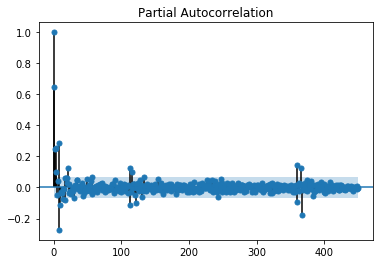

In [33]:
sm.graphics.tsa.plot_pacf(sales, lags=450)
plt.show()

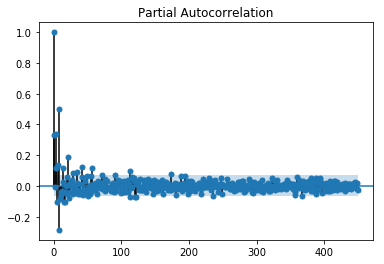

In [49]:
sales2, tmp = stats.boxcox((sales+unit_mean))
sm.graphics.tsa.plot_pacf(sales2, lags=450)
plt.show()